In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [10]:
def load_and_preprocess_data(customers_file, transactions_file):
    """
    Load and preprocess customer and transaction data.
    """
    # Load data
    customers_df = pd.read_csv(customers_file)
    transactions_df = pd.read_csv(transactions_file)

    # Convert date columns to datetime
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

    # Aggregate transaction data per customer
    trans_agg = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'TransactionDate': ['min', 'max']
    }).reset_index()

    # Rename columns
    trans_agg.columns = ['CustomerID', 'Total_Spend', 'Avg_Spend', 'Transaction_Count', 'First_Purchase', 'Last_Purchase']

    # Calculate customer lifetime (in days)
    trans_agg['Customer_Lifetime'] = (trans_agg['Last_Purchase'] - trans_agg['First_Purchase']).dt.days

    # Merge with customer data
    combined_df = customers_df.merge(trans_agg, on='CustomerID', how='inner')

    return combined_df

# Load data
combined_df = load_and_preprocess_data('Customers.csv', 'Transactions.csv')
combined_df.head()

,CustomerID,CustomerName,Region,SignupDate,Total_Spend,Avg_Spend,Transaction_Count,First_Purchase,Last_Purchase,Customer_Lifetime
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,670.904,5,2024-01-19 03:12:55,2024-11-02 17:04:16,288
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,465.685,4,2024-02-28 07:44:21,2024-12-03 01:41:41,278
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,681.345,4,2024-02-18 02:50:37,2024-08-24 18:54:04,188
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,669.360,8,2024-02-28 10:16:35,2024-12-23 14:13:52,299
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,678.080,3,2024-03-15 04:08:59,2024-11-04 00:30:22,233


In [11]:
def prepare_features(df):
    """
    Prepare features for clustering.
    """
    # Selecting relevant features
    features = ['Total_Spend', 'Avg_Spend', 'Transaction_Count', 'Customer_Lifetime']

    # Creating feature matrix
    X = df[features].copy()

    # Handling missing values
    X.fillna(X.mean(), inplace=True)

    # Standardizing the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, features

# Prepare features
X_scaled, features = prepare_features(combined_df)


In [12]:
def find_optimal_clusters(X, max_clusters=10):
    """
    Find optimal number of clusters using Davies-Bouldin Index and Elbow method.
    """
    db_scores = []
    inertias = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)

        db_scores.append(davies_bouldin_score(X, kmeans.labels_))
        inertias.append(kmeans.inertia_)

    return db_scores, inertias

# Compute metrics for choosing number of clusters
db_scores, inertias = find_optimal_clusters(X_scaled)


C:\Users\dniva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dniva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dniva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dniva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

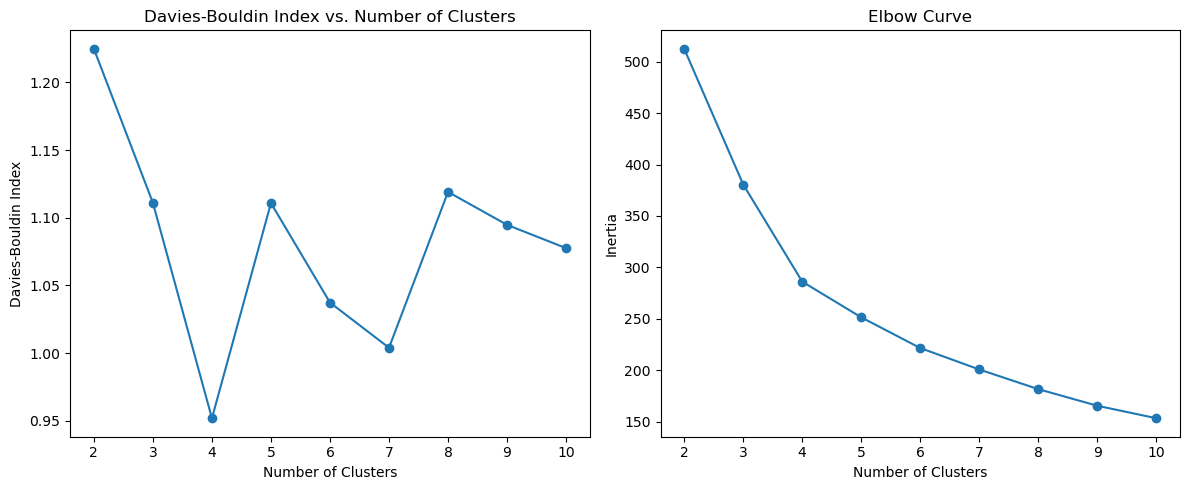

In [13]:
def plot_metrics(db_scores, inertias):
    """
    Plot Davies-Bouldin Index and Elbow Curve.
    """
    fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

    # DB Index
    ax1[0].plot(range(2, len(db_scores) + 2), db_scores, marker='o')
    ax1[0].set_xlabel('Number of Clusters')
    ax1[0].set_ylabel('Davies-Bouldin Index')
    ax1[0].set_title('Davies-Bouldin Index vs. Number of Clusters')

    # Elbow Curve
    ax1[1].plot(range(2, len(inertias) + 2), inertias, marker='o')
    ax1[1].set_xlabel('Number of Clusters')
    ax1[1].set_ylabel('Inertia')
    ax1[1].set_title('Elbow Curve')

    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metrics(db_scores, inertias)


In [14]:
def perform_clustering(X, n_clusters):
    """
    Perform KMeans clustering and return labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    return labels, kmeans

# Set the optimal number of clusters (update based on DB Index result)
optimal_clusters = 4

# Perform clustering
labels, kmeans = perform_clustering(X_scaled, optimal_clusters)


C:\Users\dniva\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [15]:
def analyze_clusters(df, labels):
    """
    Generate cluster analysis report.
    """
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels

    cluster_summary = df_with_clusters.groupby('Cluster').agg({
        'Total_Spend': 'mean',
        'Avg_Spend': 'mean',
        'Transaction_Count': 'mean',
        'Customer_Lifetime': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Cluster_Size'}).round(2)

    return cluster_summary

# Analyze clusters
cluster_summary = analyze_clusters(combined_df, labels)
cluster_summary


,Total_Spend,Avg_Spend,Transaction_Count,Customer_Lifetime,Cluster_Size
Cluster,,,,,
0,2644.90,554.10,4.85,257.53,87
1,1323.14,598.81,2.13,59.94,31
2,5754.88,744.47,7.80,285.07,46
3,4404.22,1023.23,4.37,208.26,35


In [8]:
print("\nClustering Results:")
print(f"Number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, labels):.3f}")
print("\nCluster Summary:")
print(cluster_summary)



Clustering Results:
Number of clusters: 4
Davies-Bouldin Index: 0.952

Cluster Summary:
         Total_Spend  Avg_Spend  Transaction_Count  Customer_Lifetime  \
Cluster                                                                 
0            2644.90     554.10               4.85             257.53   
1            1323.14     598.81               2.13              59.94   
2            5754.88     744.47               7.80             285.07   
3            4404.22    1023.23               4.37             208.26   

         Cluster_Size  
Cluster                
0                  87  
1                  31  
2                  46  
3                  35  
